In Bayesian approach we update our believes as we observe new data. 

A colleague of mine asked if one should update prior recursively (via Bayes theorem) as one gathers more and more data or just better off wait for an experiment to finish and infer posteriors in the very end. Will the final posteriors one would obtain from these two strategies be different?

Intuitively, and mathematically too, both the approaches should result the same posteriors assuming you start with same orginial priors in the first place.

Followings present a demo on this.

In [1]:
# Importing some libraries 

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

### Data

Create a synthetic data that is normally distributed.

In [2]:
n = 2000
mu, std = 100, 25
data = st.norm.rvs(mu, std, n)

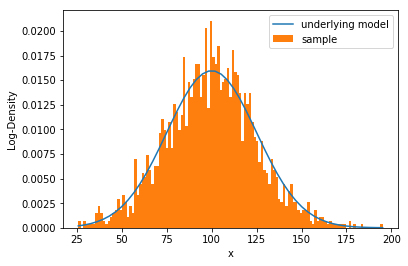

In [3]:
mup = np.linspace(1, 250, 500)

x = np.linspace(data.min(), data.max(), 50)
plt.plot(x,st.norm.pdf(x, loc=mu, scale=std), label='underlying model');
plt.hist(data, bins=125, normed=True, label='sample');
plt.legend()
plt.xlabel('x')
plt.ylabel('Log-Density')

## Prior
Two model parameters mu (mean) and std (standard-deviation) is sufficient to define a normal distribution. 

To begin with, let's assume three different priors on mu (mean of the gaussian distribution), namely, uniform, modified beta distribution, and gaussian distribution but with shifted centre (systematically). 

For the simplicitly I assume std to be fixed.

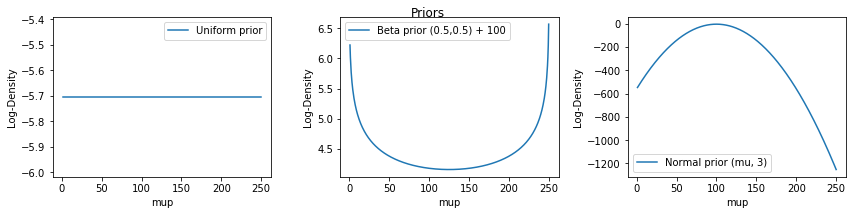

In [4]:
# priors on mu
fig1, ax = plt.subplots(1,3, figsize=(12, 3))

# Uniform prior
p1 = st.uniform.logpdf(mup, 1, 300)
ax[0].plot(mup, p1, label='Uniform prior')

# Modified beta distribution
p2 = st.beta.logpdf(mup/mup.max(), 0.5, 0.5) + np.log(mu)
ax[1].plot(mup, p2, label='Beta prior (0.5,0.5) + 100')

# Normal prior with systematic
p3 = st.norm.logpdf(mup, mu, 3)
ax[2].plot(mup, p3, label='Normal prior (mu, 3)')

for iax in ax:
    iax.set_xlabel('mup')
    iax.set_ylabel('Log-Density')
    iax.legend()

fig1.suptitle('Priors')
fig1.tight_layout()


## Likelihood

To compute the likelihood we need data. Here first let's compute likelihood for a few subsets of the data and see if they agree to some limit (of the scatter)

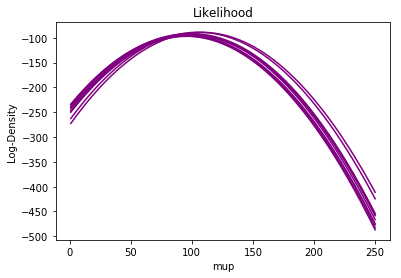

In [5]:
def total_likelihood(mu, std, data):
    yval = []
    for i in mu:
        yval.append(np.sum(st.norm.logpdf(data, loc=i, scale=std)))
    return np.asarray(yval)

# Reshaping the randomly drawn data into small batches 
batch_data = data.reshape(100,20)

# Likelihood
for ix in xrange(10):
    plt.plot(mup, total_likelihood(mup, std, batch_data[ix]), color='purple')
plt.title('Likelihood')
plt.ylabel('Log-Density')
plt.xlabel('mup')

We see the likelihoods for different sub-sets of data coincides par scatter. The functional form for the likelihood is assumed to be gaussian which is exactly what was the underlying distribution from where data were randomlydrawn. 

Next stop in the Bayesian reasoning would be weight the likelihood by prior and construct posterior distribution. 
We do this for all three priors we chose above. 

### Posterior

In [6]:
# Upon provided a list of priors and a likelihood distribution the following function returns posterior 
# corresponding to each prior, and respective figure stamps.

def plot(x, prior, likelihood):
    fig, ax = plt.subplots(1,3, figsize=(12,3))

    posteriors = []
    for iax, pr in zip(ax, prior):
        iax.plot(x, pr, label='prior', lw=2, ls='dashed', marker='.')
        iax.plot(x, likelihood, label='log-likeli', lw=2, color='purple')
    
        posterior = likelihood + pr
        
        posteriors.append(posterior)
        
        iax.plot(x, posterior, label='posterior', lw=2, color='red', ls='--')

        iax.set_xlabel('mup')
        iax.set_ylabel('Log-Density')
        iax.set_xlim(0,250)
        iax.legend()
    fig.tight_layout()
    
    return fig, ax, posteriors

### Run 

Finally in the following let's infer full posteriors. At every step for a small batch of 'observed' data we compute likelihood and posterior. For the next iteration resulted posterior will be fed as a prior and multiplied with the new likelihood obtained with new batch of 'observed' data. Below, we run this for a few iteration. 

Iteration : 0
Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14


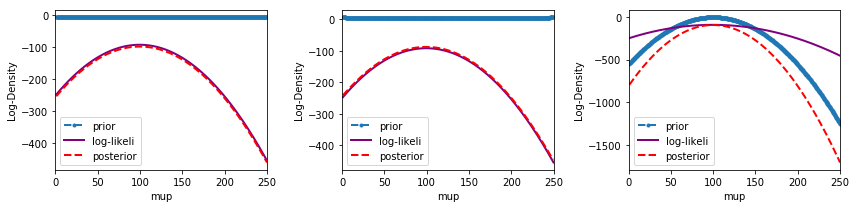

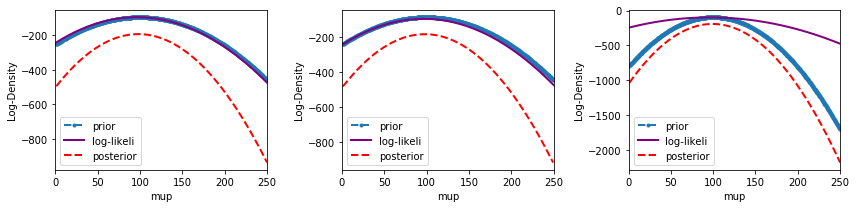

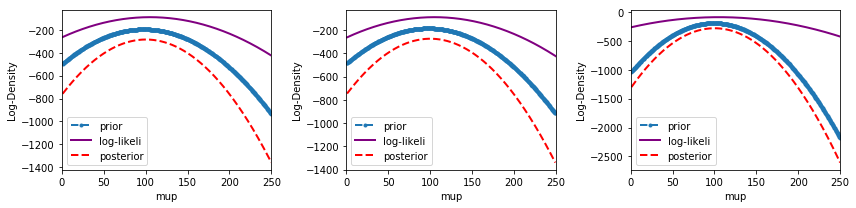

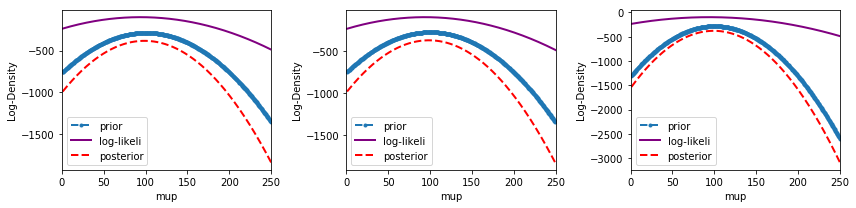

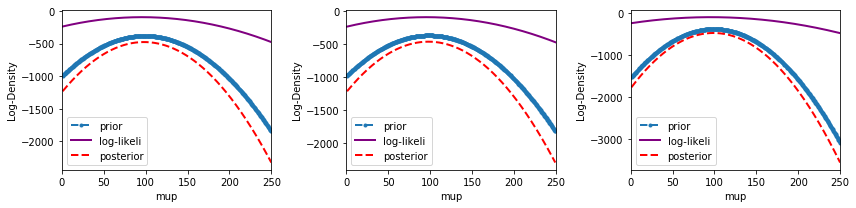

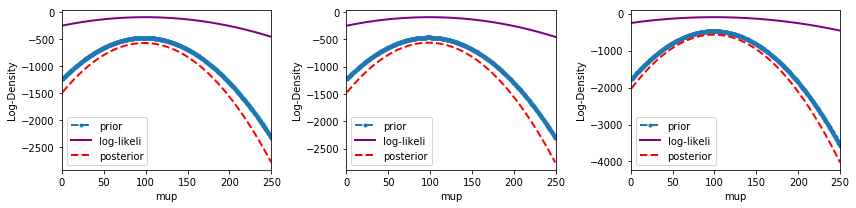

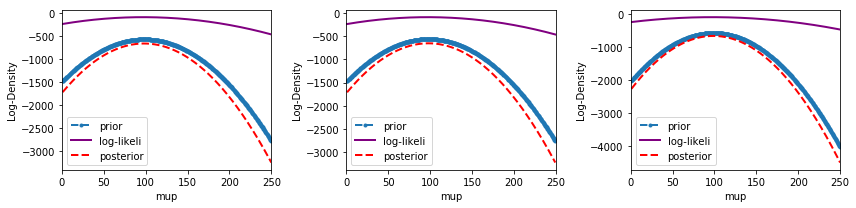

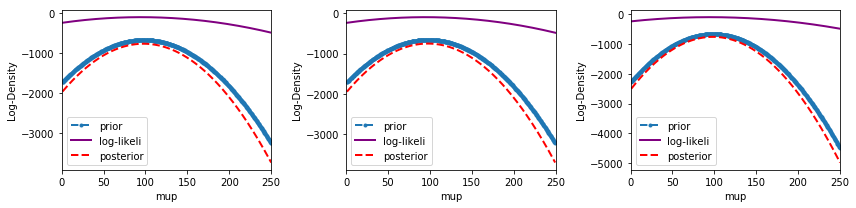

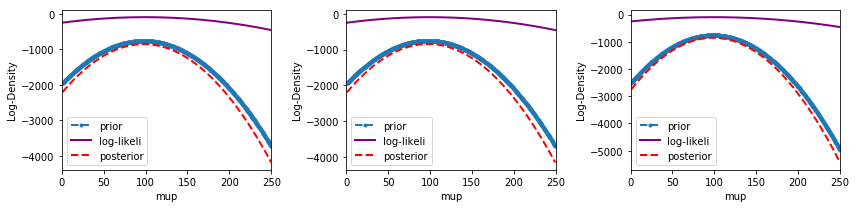

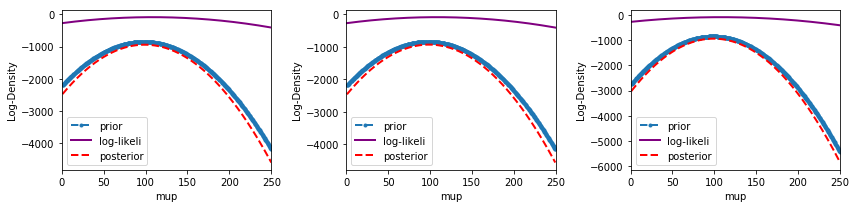

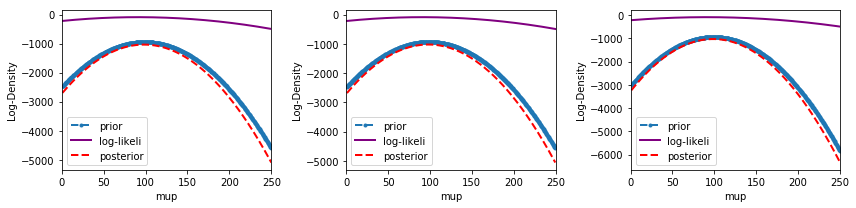

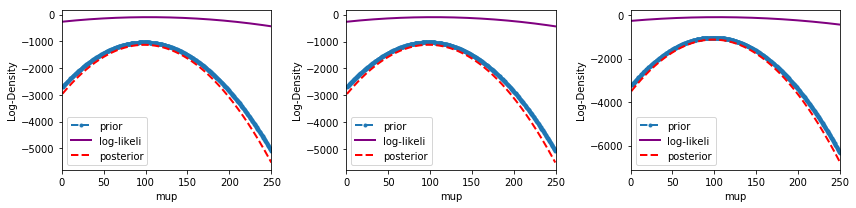

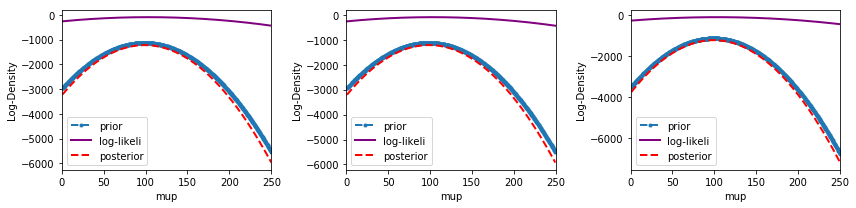

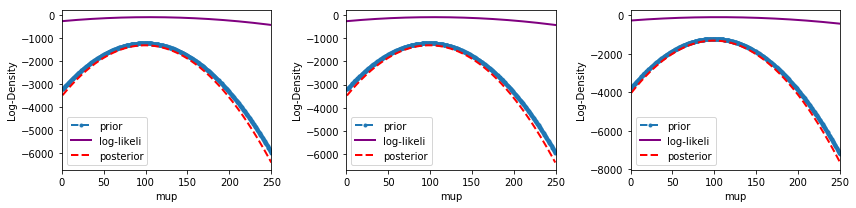

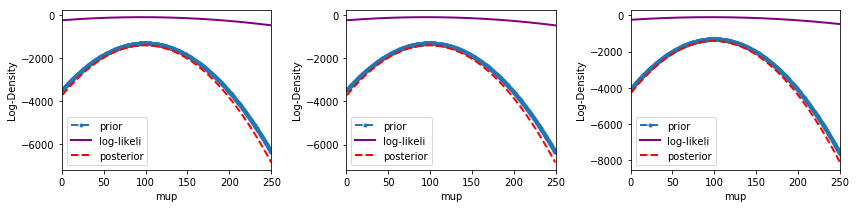

In [7]:
prior = np.asarray([p1, p2, p3])
for j in xrange(15):
    lnhood = total_likelihood(mup, std, batch_data[j])

    print 'Iteration : %d'%j
    fig, ax, posterior = plot(mup, prior, lnhood)
    prior = posterior

We see that as we progress downwards posteriors show better agreement with prior. 

### Likelihood calculation on entire data, single update

Now, it is time to infer the posteriors collectively from all the data used above in one go. 

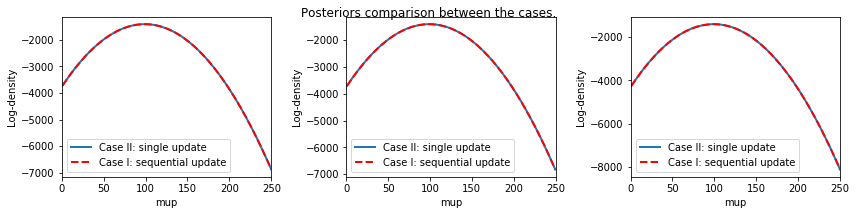

In [8]:
# These are the same priors we started in the beginning of the above case
prior = np.asarray([p1, p2, p3])

# Likelihood for the full data
lnhood_full = total_likelihood(mup, std, batch_data[:15].reshape(300))

# Posteriors and corresponding plots

fig, ax = plt.subplots(1,3, figsize=(12,3))

ax[0].plot(mup, lnhood_full + prior[0], label = 'Case II: single update', lw=2)
ax[0].plot(mup, posterior[0], 'r--', label = 'Case I: sequential update', lw=2)

ax[1].plot(mup, lnhood_full + prior[1], label = 'Case II: single update', lw=2)
ax[1].plot(mup, posterior[1], 'r--', label = 'Case I: sequential update', lw=2)

ax[2].plot(mup, lnhood_full + prior[2], label = 'Case II: single update', lw=2)
ax[2].plot(mup, posterior[2], 'r--', label = 'Case I: sequential update', lw=2)

for iax in ax:
    iax.legend()
    iax.set_xlabel('mup')
    iax.set_ylabel('Log-density')
    
    iax.set_xlim(0,250)
fig.suptitle('Posteriors comparison between the cases.')
fig.tight_layout()

That is a happy-ending. We see posteriors for both the cases agree to each other quite neatly for all three choices of priors.

One note however, in case one is dealing with large number of data points the Case I (case of sequential update) will be memory lighter than Case II (case of single update). 

Reference:

    https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/